# Fasttext RNN

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from time import time
from random import random, choice
from collections import Counter
from os import system

import numpy as np
import pandas as pd

import gensim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sru

from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import torchtext

from tensorboardX import SummaryWriter
from tqdm import tqdm as tqdm

from torchqrnn import QRNN

np.random.seed(42)
CUDA = torch.cuda.is_available()

CUDA

True

In [3]:
BATCH_SIZE = 32
VALID_SIZE = 0.1

NOISE_LEVEL = 0.1

NOISE_LEVELS = [0, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]

# Data preparation

In [11]:
%%time
# 5 min
fasttext = gensim.models.FastText.load_fasttext_format('/media/data/nlp/data/wiki.en.bin')
# fasttext = gensim.models.FastText.load_fasttext_format('/media/data/nlp/data/wiki.ru.bin')

CPU times: user 5min 8s, sys: 6.93 s, total: 5min 15s
Wall time: 5min 15s


In [5]:
# yes, spacy really helps
fasttext.similarity('mixed', 'mixed,')

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


0.652127500405513

### IMDB

In [6]:
MAXLEN = 256  # now it's words, not symbols

# without spacy tokenizer it's commas all after the words =(

text_field = torchtext.data.Field(
    lower=True, include_lengths=False, fix_length=MAXLEN, tensor_type=torch.FloatTensor, batch_first=True,
    use_vocab=False, tokenize='spacy'
)
label_field = torchtext.data.Field(sequential=False, use_vocab=False)

In [5]:
%%time
# Do not need this!
train, test = torchtext.datasets.imdb.IMDB.splits(text_field, label_field)

CPU times: user 1min 8s, sys: 1.24 s, total: 1min 10s
Wall time: 1min 15s


In [9]:
def preprocess_text_without_noise(text):
    vectors = []
    
    _text_tensor = torch.zeros([MAXLEN, fasttext.vector_size])

    for i, token in enumerate(text):
        if i >= MAXLEN:
            break

        if token in fasttext:
            token_vec = fasttext[token]
        else:
            token_vec = fasttext['unk']  # is this real <UNK> token?
        token_tensor = torch.FloatTensor(token_vec)
        _text_tensor[i, :] = token_tensor

    return _text_tensor

class FastTextNoisedIMDB(torchtext.datasets.imdb.IMDB):
    """
    Zero vector used for padding
    """
    noise_level = 0
    # alphabet from the paper
    # https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf
    alphabet = ['\n'] + [s for s in """ abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&* ̃‘+-=<>()[]{}"""]

    def __getitem__(self, idx):
        item = super(FastTextNoisedIMDB, self).__getitem__(idx)
        vectors = []
        # indicies orded different from previous models — (word_vec, word_num) instead of (word_num, word_vec)
        _text_tensor = torch.zeros([MAXLEN, fasttext.vector_size])

        for i, token in enumerate(item.text):
            if i >= MAXLEN:
                break

            token = self.noise_generator(token)  # это плохо?
            if token in fasttext:
                token_vec = fasttext[token]
            else:
                token_vec = fasttext['unk']  # is this real <UNK> token?
            token_tensor = torch.FloatTensor(token_vec)
            _text_tensor[i, :] = token_tensor

        label = int(item.label == 'pos')
        return _text_tensor, label

    def noise_generator(self, string):
        # removed '' symbol from alphabet for safety on word vectors
        noised = ""
        for c in string:
            if random() > self.noise_level:
                noised += c
            if random() < self.noise_level:
                noised += choice(self.alphabet)
        return noised

def get_train_valid_loader(dataset, valid_size, batch_size, random_seed=42, shuffle=True, num_workers=4):

    len_dataset = len(dataset)
    indices = list(range(len_dataset))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    val_actual_size = int(len_dataset * valid_size)

    train_idx, valid_idx = indices[:-val_actual_size], indices[-val_actual_size:]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=4
    )

    return train_loader, valid_loader


In [10]:
%%time
train, test = FastTextNoisedIMDB.splits(text_field, label_field)

CPU times: user 1min 8s, sys: 976 ms, total: 1min 9s
Wall time: 1min 14s


### Mokoron

In [5]:
from random import random
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize

# MAX_TEXT_LEN = MAXLEN = 32
MAX_TEXT_LEN = MAXLEN = 128

ALPHABET = ['<UNK>'] + ['\n'] + [s for s in """ 0123456789-,;.!?:'’’/\|_@#$%ˆ&* ̃‘+-=<>()[]{}"""]
# ALPHABET += [s for s in 'абвгдеёжзийклмнопрстуфхцчщъыьэюя']
ALPHABET += [s for s in 'abcdefghijklmnopqrstuvwxyz']

# ALPHABET = [s for s in ALPHABET if s not in ('(', ')')]

ALPHABET_LEN = len(ALPHABET)
char2int = {s: i for s, i in zip(ALPHABET, range(ALPHABET_LEN))}


class FastTextMokoron(torch.utils.data.Dataset):
    """
    Zero vector used for padding
    """
    noise_level = 0
    alphabet = ALPHABET

    def __init__(self, filepath, text_field, maxlen=MAX_TEXT_LEN):
        self.alphabet = ALPHABET

        self.mystem = Mystem()
        self.text_field = text_field
        self.data = pd.read_csv(filepath)
        self.maxlen = maxlen
        self.char2int = {s: i for s, i in zip(self.alphabet, range(len(self.alphabet)))}

    def __len__(self):
        return len(self.data)

    def _tokenize(self, text):
        return word_tokenize(text)
#         return [res['text'] for res in self.mystem.analyze(text) if res['text'] != ' ']

    def __getitem__(self, idx):
        line = self.data.iloc[idx]
        text = line[self.text_field].lower()
        label = int(line.sentiment == 1.)

        if self.noise_level > 0:
            text = self._noise_generator(text)

        text = self._tokenize(text)
        text = self._preprocess(text)
        return text, label

    def _preprocess(self, text):
        vectors = []
        # indicies orded different from previous models — (word_vec, word_num) instead of (word_num, word_vec)
        _text_tensor = torch.zeros([MAXLEN, fasttext.vector_size])

        for i, token in enumerate(text):
            if i >= MAXLEN:
                break

            if token in fasttext:
                token_vec = fasttext[token]
            else:
                token_vec = fasttext['unk']  # is this real <UNK> token?
            token_tensor = torch.FloatTensor(token_vec)
            _text_tensor[i, :] = token_tensor

        return _text_tensor

    def _noise_generator(self, string):
        noised = ""
        for c in string:
            if random() > self.noise_level:
                noised += c
            if random() < self.noise_level:
                noised += choice(self.alphabet)
        return noised


In [6]:
def get_metrics(model, test_data, noise_level=None):
    """
    :param test_data: dataset or dataloader

    Moder will be in TRAIN mode after that
    """
    model.eval()

    predictions = []
    lables = []
    
    if isinstance(test_data, torch.utils.data.Dataset):
        if noise_level is not None:
            test_data.noise_level = noise_level

        test_dataloader = torch.utils.data.DataLoader(
            test_data, batch_size=BATCH_SIZE
        )
    else:
        assert isinstance(test_data, torch.utils.data.DataLoader)
        test_dataloader = test_data

    for text, label in test_dataloader:
        if CUDA:
            text = Variable(text.cuda())
        else:
            text = Variable(text)

        text = text.permute(1, 0, 2)  # (1, 0, 2) for RNN
        prediction = model(text)

        _, idx = torch.max(prediction, 1)
        predictions += idx.data.tolist()
        lables += label.tolist()

    acc = accuracy_score(lables, predictions)
    f1 = f1_score(lables, predictions)
    model.train()
    return {'accuracy': acc, 'f1': f1}


### IMDB

In [13]:
dataloader, val_dataloader = get_train_valid_loader(train, VALID_SIZE, BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(
    test, batch_size=BATCH_SIZE
)

### Mokoron

In [ ]:
basepath = '/media/data/nlp/sentiment/ru-mokoron/splits/'

In [7]:
basepath = '/media/data/nlp/sentiment/IMDB/splits/'

In [24]:
train = FastTextMokoron(basepath + 'train.csv', 'text_original')
valid = FastTextMokoron(basepath + 'validation.csv', 'text_original')
test = FastTextMokoron(basepath + 'test.csv', 'text_original')

test_original = FastTextMokoron(basepath + 'test.csv', 'text_original')

dataloader = torch.utils.data.DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(valid, BATCH_SIZE, shuffle=True, num_workers=4)

# Model

In [22]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_dim, num_layers=1, dropout=0.5, type_='GRU'):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout

        if type_ == 'SRU':
            self.rnn = sru.SRU(fasttext.vector_size, hidden_dim, num_layers=num_layers)
        elif type_ == 'GRU':
            self.rnn = nn.GRU(fasttext.vector_size, hidden_dim, num_layers=num_layers)
        elif type_ == 'QRNN':
            self.rnn = QRNN(fasttext.vector_size, hidden_dim, num_layers=num_layers)
        elif type_ == 'LSTM': 
            self.rnn = nn.LSTM(fasttext.vector_size, hidden_dim, num_layers=num_layers)
        else:
            raise ValueError('Wrong type_', type_)
        self.dropout = nn.Dropout(self.dropout_prob)
        self.projector = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x, c_states = self.rnn(x)
        x = self.dropout(x[-1])
        x = self.projector(x)
        return x


In [21]:
def model_params_num(model):
    return sum(np.prod(list(p.size())) for p in model.parameters())

def mk_dataline(model_type, epochs, lr, noise_level_train, noise_level_test, acc_train, acc_test,
                f1_train, f1_test, dropout, model, run_name, task, init_function=None):
    return {
        'task': task,
        'model_type': model_type,
        'trainable_params': model_params_num(model), 'dropout': dropout, 'init_function': init_function,
        'epochs': epochs, 'lr': lr,
        'noise_level_train': noise_level_train, 'noise_level_test': noise_level_test,
        'acc_train': acc_train, 'acc_test': acc_test,
        'f1_train': f1_train, 'f1_test': f1_test,
        'model_desc': str(model),
        'run_name': run_name,
        'data_desc': 'Maxlen %s' % MAXLEN
    }

In [20]:
results = []

In [19]:
def run_model_with(noise_level, hidden, lr=1e-4, dropout=0.5, layers=1,
                   epochs=30, type_='GRU', _model=None, comment='', log_every=1):
    start_time = time()
#     CharIMDB.noise_level = noise_level
    task='IMDB binary classification'
    FastTextMokoron.noise_level = noise_level
#     task='Mokoron binary classification'

    if _model is None:
        model = SimpleRNN(hidden, num_layers=layers, dropout=dropout, type_=type_)
        if CUDA:
            model.cuda()
        model.train()
    
    else:
        model = _model
        
    model_name = '_FastText%s_lr%s_dropout%s_embed_layers%s_hidden%s_noise_level%s' %(
        type_, int(-np.log10(lr)), dropout, layers, hidden, noise_level
    ) + comment

    if '(' not in ALPHABET:
        model_name += '_no_emoji'

    writer = SummaryWriter(comment=model_name)
    if len(list(writer.all_writers.keys())) > 1:
        print('More than one writer! 0_o')
        print(list(writer.all_writers.keys()))

    run_name = list(writer.all_writers.keys())[0]
    print('Writer: %s' % run_name)

    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    optimizer.zero_grad()
    
    global_step = 0

    loss_f = F.cross_entropy

    for epoch in range(epochs):

        for batch_idx, (text, label) in enumerate(dataloader):
            optimizer.zero_grad()

            if CUDA:
                text = Variable(text.cuda())
                label = Variable(torch.LongTensor(label).cuda())
            else:
                text = Variable(text)
                label = Variable(torch.LongTensor(label))

            text = text.permute(1, 0, 2)
            prediction = model(text)
            loss = loss_f(prediction, label)

            writer.add_scalar('loss', loss.data[0], global_step=global_step)

            loss.backward()        
            torch.nn.utils.clip_grad_norm(model.parameters(), 1e-1)
            optimizer.step()

            if CUDA:
                torch.cuda.synchronize()
            global_step += 1

        # evaluation
        if epoch % log_every == 0:
            print('Epoch %s. Global step %s. T=%s min' % (epoch, global_step, (time() - start_time) / 60.))
            print('Loss               : %s' % loss.data[0])

        # in-batch
        _, idx = torch.max(prediction, 1)
        _labels = label.data.tolist()
        _predictions = idx.data.tolist()
        acc = accuracy_score(_labels, _predictions)
        f1 = f1_score(_labels, _predictions)
        writer.add_scalar('accuracy_train', acc, global_step=global_step)
        writer.add_scalar('f1_train', f1, global_step=global_step)
        if epoch % log_every == 0:
            print('In-batch accuracy  :', acc)

        # validation
        metrics = get_metrics(model, val_dataloader)
        if epoch % log_every == 0:
            print('Validation accuracy: %s, f1: %s' % (metrics['accuracy'], metrics['f1']))
            print()

        writer.add_scalar('accuracy_val', metrics['accuracy'], global_step=global_step)
        writer.add_scalar('f1_val', metrics['f1'], global_step=global_step)

    with open('models/%s.torch' % run_name.split('/')[-1], 'wb') as f:
        try:
            torch.save(model, f)
        except Exception as e:
            print(e)
            print('Continuing (probably) without saving')
        
    # Test
    model.eval()

    metrics_test = None

    print('Calculating validation metrics... Time %s min' % ((time() - start_time) / 60.))
    metrics_train = get_metrics(model, dataloader)
    acc_train = metrics_train['accuracy']
    f1_train = metrics_train['f1']

    for test_noise in tqdm(NOISE_LEVELS):
        metrics = get_metrics(model, test, test_noise)
        if test_noise == noise_level:
            metrics_test = metrics

        acc_test = metrics['accuracy']
        f1_test = metrics['f1']
        results.append(mk_dataline(
            model_type='FasttextGRU', epochs=epochs, lr=lr,
            noise_level_train=noise_level, acc_train=acc_train, f1_train=f1_train,
            noise_level_test=test_noise, acc_test=acc_test, f1_test=f1_test,
            dropout=dropout, model=model,
            init_function=None,
            run_name=run_name,
            task=task
        ))
    
    # test original
    metrics = get_metrics(model, test_original)
    results.append(mk_dataline(
        model_type='FasttextGRU', epochs=epochs, lr=lr,
        noise_level_train=noise_level, acc_train=acc_train, f1_train=f1_train,
        noise_level_test=-1, acc_test=metrics['accuracy'], f1_test=metrics['f1'],
        dropout=dropout, model=model,
        init_function=None,
        run_name=run_name,
        task=task
    ))
    
    print('Original dataset: acc %s, f1 %s' % (metrics['accuracy'], metrics['f1']))
    writer.add_scalar('accuracy_test_original', metrics['accuracy'], global_step=global_step)
    writer.add_scalar('f1_test_original', metrics['f1'], global_step=global_step)

    print('Final test metrics: %s, Time %s min' % (metrics_test, ((time() - start_time) / 60.)))
    if metrics_test is not None:
        writer.add_scalar('accuracy_test_final', metrics_test['accuracy'], global_step=global_step)
        writer.add_scalar('f1_test_final', metrics_test['f1'], global_step=global_step)
    print()
    # model is in EVAL mode!
    return model

# Main exp

In [15]:
test.text_field, MAXLEN

('text_spellchecked', 128)

In [16]:
test.data.sample()

,Unnamed: 0,sentiment,text_original,text_spellchecked
6868,6868,True,before seeing the sneak preview today of angel...,before seeing the sneak preview today of angel...


In [17]:
test._tokenize('Hello, apple.inc!')

['Hello', ',', 'apple.inc', '!']

In [ ]:
for noise_level in tqdm(NOISE_LEVELS):
    model = run_model_with(
        noise_level=noise_level, hidden=256, lr=1e-4, dropout=0.5, layers=1,
        log_every=10, comment='_IMDB'
    )
    pd.DataFrame(results).to_csv('results/FastTextGRU_IMDB.csv')

  0%|          | 0/11 [00:00<?, ?it/s]

Writer: runs/May16_14-54-06_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0_IMDB
Epoch 0. Global step 665. T=0.482096529006958 min
Loss               : 0.10390615463256836
In-batch accuracy  : 1.0
Validation accuracy: 0.7266666666666667, f1: 0.7245364149422198

Epoch 10. Global step 7315. T=6.637127212683359 min
Loss               : 0.21501517295837402
In-batch accuracy  : 1.0
Validation accuracy: 0.816, f1: 0.8100220264317181

Epoch 20. Global step 13965. T=13.12221892674764 min
Loss               : 0.35207149386405945
In-batch accuracy  : 1.0
Validation accuracy: 0.8288, f1: 0.8314960629921261

Calculating validation metrics... Time 19.057762833436332 min



  9%|▉         | 1/11 [44:42<7:27:04, 2682.45s/it]

Original dataset: acc 0.8348, f1 0.8326715825297788
Final test metrics: {'f1': 0.8320499311015643, 'accuracy': 0.83424}, Time 44.707474493980406 min

Writer: runs/May16_15-38-47_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0.005_IMDB
Epoch 0. Global step 665. T=0.5602811892827352 min
Loss               : 0.29145094752311707
In-batch accuracy  : 1.0
Validation accuracy: 0.7245333333333334, f1: 0.7361430395913154

Epoch 10. Global step 7315. T=7.4568472901980085 min
Loss               : 0.16636188328266144
In-batch accuracy  : 1.0
Validation accuracy: 0.7992, f1: 0.7807860262008733

Epoch 20. Global step 13965. T=14.908810810248058 min
Loss               : 0.1062106192111969
In-batch accuracy  : 1.0
Validation accuracy: 0.8053333333333333, f1: 0.7860492379835874

Calculating validation metrics... Time 21.36502576669057 min



 18%|█▊        | 2/11 [1:29:00<6:40:31, 2670.20s/it]

Original dataset: acc 0.83452, f1 0.8352383607471424
Final test metrics: {'f1': 0.8361797842270792, 'accuracy': 0.8354}, Time 44.29902568658193 min

Writer: runs/May16_16-23-05_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0.01_IMDB
Epoch 0. Global step 665. T=0.4540437420209249 min
Loss               : 0.24428507685661316
In-batch accuracy  : 1.0
Validation accuracy: 0.7122666666666667, f1: 0.7016864805087089

Epoch 10. Global step 7315. T=6.501604131857554 min
Loss               : 0.13319262862205505
In-batch accuracy  : 1.0
Validation accuracy: 0.7768, f1: 0.80245456691055

Epoch 20. Global step 13965. T=12.817986365159353 min
Loss               : 0.21399624645709991
In-batch accuracy  : 1.0
Validation accuracy: 0.8029333333333334, f1: 0.7837284167398302

Calculating validation metrics... Time 18.940122163295747 min



 27%|██▋       | 3/11 [2:11:07<5:49:39, 2622.48s/it]

Original dataset: acc 0.83036, f1 0.8310291246663214
Final test metrics: {'f1': 0.8305745662899889, 'accuracy': 0.82968}, Time 42.11713352203369 min

Writer: runs/May16_17-05-12_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0.025_IMDB
Epoch 0. Global step 665. T=0.5466146866480509 min
Loss               : 0.6144958734512329
In-batch accuracy  : 0.5
Validation accuracy: 0.6472, f1: 0.7188097768331562

Epoch 10. Global step 7315. T=7.107598149776459 min
Loss               : 0.03806668519973755
In-batch accuracy  : 1.0
Validation accuracy: 0.7653333333333333, f1: 0.7964847363552267

Epoch 20. Global step 13965. T=13.983897999922435 min
Loss               : 0.6510157585144043
In-batch accuracy  : 0.5
Validation accuracy: 0.7997333333333333, f1: 0.7950886766712142

Calculating validation metrics... Time 19.71455333630244 min



 36%|███▋      | 4/11 [2:53:31<5:03:39, 2602.85s/it]

Original dataset: acc 0.81304, f1 0.8123795761078998
Final test metrics: {'f1': 0.8130923694779117, 'accuracy': 0.81384}, Time 42.399056772391 min

Writer: runs/May16_17-47-36_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0.05_IMDB
Epoch 0. Global step 665. T=0.6330066839853923 min
Loss               : 1.0642449855804443
In-batch accuracy  : 0.0
Validation accuracy: 0.5682666666666667, f1: 0.6561902739435125

Epoch 10. Global step 7315. T=8.076750179131826 min
Loss               : 1.1081478595733643
In-batch accuracy  : 0.5
Validation accuracy: 0.7530666666666667, f1: 0.7754607177497576

Epoch 20. Global step 13965. T=15.547609841823578 min
Loss               : 0.0592690110206604
In-batch accuracy  : 1.0
Validation accuracy: 0.7725333333333333, f1: 0.7745175786412901

Calculating validation metrics... Time 22.415431622664133 min


In [ ]:
model = run_model_with(
    noise_level=0, hidden=256, lr=1e-4, dropout=0.5, layers=1,
    log_every=10, comment='_IMDB_unchanged'
)

Writer: runs/May17_00-35-32_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0_IMDB_unchanged
Epoch 0. Global step 665. T=0.48949044148127235 min
Loss               : 0.2544324994087219
In-batch accuracy  : 1.0
Validation accuracy: 0.6850666666666667, f1: 0.6376189015035287

Epoch 10. Global step 7315. T=6.421221252282461 min
Loss               : 0.5222145318984985
In-batch accuracy  : 0.5
Validation accuracy: 0.8157333333333333, f1: 0.8070371404635578

Epoch 20. Global step 13965. T=12.081395522753398 min
Loss               : 0.4962387681007385
In-batch accuracy  : 1.0
Validation accuracy: 0.8304, f1: 0.8369230769230769

Calculating validation metrics... Time 17.252040696144103 min


  9%|▉         | 1/11 [01:15<12:39, 75.95s/it]

In [29]:
pd.DataFrame(results[-12:])

,acc_test,acc_train,data_desc,dropout,epochs,f1_test,f1_train,init_function,lr,model_desc,model_type,noise_level_test,noise_level_train,run_name,task,trainable_params
0,0.83264,0.894118,Maxlen 128,0.5,30,0.841094,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.000,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
1,0.82620,0.894118,Maxlen 128,0.5,30,0.833148,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.005,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
2,0.82036,0.894118,Maxlen 128,0.5,30,0.825178,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.010,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
3,0.78732,0.894118,Maxlen 128,0.5,30,0.783042,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.025,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
4,0.72668,0.894118,Maxlen 128,0.5,30,0.691415,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.050,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
5,0.65984,0.894118,Maxlen 128,0.5,30,0.569156,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.075,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
6,0.60696,0.894118,Maxlen 128,0.5,30,0.446173,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.100,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
7,0.57032,0.894118,Maxlen 128,0.5,30,0.340172,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.125,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
8,0.54332,0.894118,Maxlen 128,0.5,30,0.244758,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.150,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058
9,0.52444,0.894118,Maxlen 128,0.5,30,0.172939,0.89904,None,0.0001,"SimpleRNN(\n (rnn): GRU(300, 256)\n (dropout...",FasttextGRU,0.175,0,runs/May17_00-35-32_phobos-aijun_FastTextGRU_l...,IMDB binary classification,429058


In [19]:
model = run_model_with(
    noise_level=0, hidden=256, lr=1e-4, dropout=0.5, layers=1,
    log_every=10, comment='_mokoron'
)

Writer: runs/May15_20-50-31_phobos-aijun_FastTextGRU_lr4_dropout0.5_embed_layers1_hidden256_noise_level0_mokoron_no_emoji
Epoch 0. Global step 4757. T=0.9961188077926636 min
Loss               : 0.5088668465614319
In-batch accuracy  : 0.6875
Validation accuracy: 0.7015575177826834, f1: 0.7203034308373083

Epoch 10. Global step 52327. T=18.330225523312887 min
Loss               : 0.7137598395347595
In-batch accuracy  : 0.625
Validation accuracy: 0.758523424086338, f1: 0.7706464764123471

Epoch 20. Global step 99897. T=39.32274415890376 min
Loss               : 0.478054404258728
In-batch accuracy  : 0.75
Validation accuracy: 0.7633676723080697, f1: 0.77436707010466

Calculating validation metrics... Time 58.73437697490056 min


100%|██████████| 11/11 [10:02<00:00, 54.79s/it]


Original dataset: acc 0.7515023301447142, f1 0.7636406054066665
Final test metrics: {'accuracy': 0.7515023301447142, 'f1': 0.7636406054066665}, Time 70.85603164037069 min



In [50]:
pd.DataFrame(results[13:]).to_csv('results/FastTextGRU_mokoron_dropout_0.csv')

In [44]:
pd.DataFrame(results).to_csv('results/FastTextGRU_mokoron.csv')

In [40]:
%%time
# GRU
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=1, comment='_test')

Writer: runs/May14_01-42-08_phobos-aijun_FastTextGRU_lr4_dropout0_embed_layers1_hidden256_noise_level0_test_no_emoji
Epoch 0. Global step 4757. T=0.7734807093938192 min
Loss               : 0.5994613170623779
In-batch accuracy  : 0.6875
Validation accuracy: 0.7010976207996076, f1: 0.7286744037182378

Calculating validation metrics... Time 0.9670534292856853 min
Original dataset: acc 0.6916850625459897, f1 0.7213323726652995
Final test metrics: {'accuracy': 0.6934633308805495, 'f1': 0.7225090202608937}, Time 8.965493623415629 min

CPU times: user 5min 25s, sys: 15.2 s, total: 5min 40s
Wall time: 8min 57s


In [14]:
%%time
# GRU
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=10)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 704
Loss after epoch 0: 0.7190814018249512
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6824



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 1.0912714004516602
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7912



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2112
Loss after epoch 2: 0.7812687158584595
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7528



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.1188812255859375
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7752



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.8835945725440979
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8104



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.5482320785522461
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8316



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.08233733475208282
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationW

Validation accuracy: 0.8272



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 0.268466979265213
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8392



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.15286293625831604
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8496



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.32289454340934753
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8536



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Final test accuracy: 0.85264



In [13]:
%%time
# SRU
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=10)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

SRU loaded for gpu 0
Global step: 704
Loss after epoch 0: 0.6926696300506592
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.514



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 0.6539127826690674
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.522



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2112
Loss after epoch 2: 0.615942120552063
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5132



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.741698145866394
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.516



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.7316657304763794
In-batch accuracy: 0.25


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5144



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.744186282157898
In-batch accuracy: 0.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5152



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.6500684022903442
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5136



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 0.7124209403991699
In-batch accuracy: 0.25


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5192



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.6951999664306641
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.5192



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.7140703797340393
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.508



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Final test accuracy: 0.51716

CPU times: user 1min 50s, sys: 33.9 s, total: 2min 24s
Wall time: 4min 19s


In [14]:
%%time
# SRU
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=2, epochs=10)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 704
Loss after epoch 0: 0.8154311776161194
In-batch accuracy: 0.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5148



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 0.6932230591773987
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5148



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2112
Loss after epoch 2: 0.6589704751968384
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5224



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.6360920667648315
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.5232



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.6161527633666992
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.528



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.6660326719284058
In-batch accuracy: 0.25


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5296



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.7464239001274109
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.5308



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 0.7344444394111633
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5372



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.5349473357200623
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5952



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.5193271040916443
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6088



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Final test accuracy: 0.60036

CPU times: user 2min 1s, sys: 39.1 s, total: 2min 40s
Wall time: 4min 45s


In [19]:
%%time
# QRNN
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=2, epochs=10)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 704
Loss after epoch 0: 0.6622061729431152
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5136



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 0.5500659942626953
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationW

Validation accuracy: 0.5228



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2112
Loss after epoch 2: 0.6933540105819702
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5228



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.6931509971618652
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationW

Validation accuracy: 0.5272



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.6054344773292542
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.532



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.6591048836708069
In-batch accuracy: 0.25


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5376



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.7042015790939331
In-batch accuracy: 0.25


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5428



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 0.5698127150535583
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.5836



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.2964598834514618
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.616



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.5266984105110168
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.618



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Final test accuracy: 0.59948

CPU times: user 2min 6s, sys: 39.2 s, total: 2min 45s
Wall time: 4min 46s


In [21]:
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=2, epochs=10, _model=model)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 704
Loss after epoch 0: 0.5937803983688354
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6212



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 0.5280511379241943
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.63



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2112
Loss after epoch 2: 0.30655035376548767
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.616



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.351368248462677
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6212



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.4106287956237793
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6276



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.5901694893836975
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6268



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.41443994641304016
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.6192



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 0.9079482555389404
In-batch accuracy: 0.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.62



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.5216034650802612
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6188



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.5587573647499084
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6324



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Final test accuracy: 0.62456



In [13]:
model = run_model_with(noise_level=0.05, hidden=256, lr=1e-4, dropout=0, layers=2, epochs=20)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 704
Loss after epoch 0: 0.743602991104126
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.5264



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 0.8838710784912109
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6628



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationW

Global step: 2112
Loss after epoch 2: 0.7418651580810547
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7208



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.1845681518316269
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7352



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.12469896674156189
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7772



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.22473672032356262
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7684



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.2771795094013214
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7396



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 0.4718285799026489
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.792



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.2609866261482239
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.7152



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.26254719495773315
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.7924



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

CuDNNError: 8: b'CUDNN_STATUS_EXECUTION_FAILED'

In [ ]:
model = run_model_with(noise_level=0.1, hidden=256, lr=1e-4, dropout=0, layers=2, epochs=20)

In [16]:
%%time
# GRU
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 704
Loss after epoch 0: 0.6053268909454346
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.6932



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 1408
Loss after epoch 1: 0.40417376160621643
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.7944



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2112
Loss after epoch 2: 0.15836097300052643
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8056



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 2816
Loss after epoch 3: 0.1797385811805725
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8156



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 3520
Loss after epoch 4: 0.06198158860206604
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8156



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4224
Loss after epoch 5: 0.2025739550590515
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8188



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 4928
Loss after epoch 6: 0.3051873445510864
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8328



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 5632
Loss after epoch 7: 1.164061427116394
In-batch accuracy: 0.5


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationW

Validation accuracy: 0.8228



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 6336
Loss after epoch 8: 0.719255805015564
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8404



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7040
Loss after epoch 9: 0.16971132159233093
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8504



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 7744
Loss after epoch 10: 0.5885798335075378
In-batch accuracy: 0.75


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8592



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 8448
Loss after epoch 11: 0.08622866868972778
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8552



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: Deprecatio

Global step: 9152
Loss after epoch 12: 0.32280197739601135
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8688



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 9856
Loss after epoch 13: 0.2941758632659912
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationW

Validation accuracy: 0.8568



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Global step: 10560
Loss after epoch 14: 0.22987067699432373
In-batch accuracy: 1.0


/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: Deprecatio

Validation accuracy: 0.8676



/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/phobos_aijun/.virtualenvs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Final test accuracy: 0.86576

CPU times: user 4min 25s, sys: 1min 18s, total: 5min 44s
Wall time: 7min 1s


In [16]:
%%time
# GRU
model = run_model_with(noise_level=0.1, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

Global step: 704
Loss after epoch 0: 0.6970053911209106
In-batch accuracy: 0.75
Validation accuracy: 0.512

Global step: 1408
Loss after epoch 1: 0.6348756551742554
In-batch accuracy: 0.75
Validation accuracy: 0.6304

Global step: 2112
Loss after epoch 2: 0.7978734374046326
In-batch accuracy: 0.0
Validation accuracy: 0.5308

Global step: 2816
Loss after epoch 3: 0.8722429871559143
In-batch accuracy: 0.25
Validation accuracy: 0.6944

Global step: 3520
Loss after epoch 4: 0.515184760093689
In-batch accuracy: 0.75
Validation accuracy: 0.7268

Global step: 4224
Loss after epoch 5: 0.6328344941139221
In-batch accuracy: 0.75
Validation accuracy: 0.7076

Global step: 4928
Loss after epoch 6: 0.43832963705062866
In-batch accuracy: 0.75
Validation accuracy: 0.7232

Global step: 5632
Loss after epoch 7: 0.4712787866592407
In-batch accuracy: 0.75
Validation accuracy: 0.7568

Global step: 6336
Loss after epoch 8: 0.5772660970687866
In-batch accuracy: 0.75
Validation accuracy: 0.744

Global step: 7

In [17]:
%%time
# GRU
model = run_model_with(noise_level=0.05, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

Global step: 704
Loss after epoch 0: 0.677110493183136
In-batch accuracy: 0.5
Validation accuracy: 0.52

Global step: 1408
Loss after epoch 1: 0.5442652702331543
In-batch accuracy: 0.75
Validation accuracy: 0.6984

Global step: 2112
Loss after epoch 2: 0.25490373373031616
In-batch accuracy: 1.0
Validation accuracy: 0.7036

Global step: 2816
Loss after epoch 3: 0.35256898403167725
In-batch accuracy: 1.0
Validation accuracy: 0.7604

Global step: 3520
Loss after epoch 4: 0.5498431324958801
In-batch accuracy: 0.75
Validation accuracy: 0.7608

Global step: 4224
Loss after epoch 5: 0.889620840549469
In-batch accuracy: 0.5
Validation accuracy: 0.776

Global step: 4928
Loss after epoch 6: 0.5614051818847656
In-batch accuracy: 0.75
Validation accuracy: 0.7912

Global step: 5632
Loss after epoch 7: 0.3959411084651947
In-batch accuracy: 0.75
Validation accuracy: 0.7876

Global step: 6336
Loss after epoch 8: 0.6688700914382935
In-batch accuracy: 0.75
Validation accuracy: 0.7896

Global step: 7040


In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.01, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

Global step: 704
Loss after epoch 0: 0.46561628580093384
In-batch accuracy: 0.75
Validation accuracy: 0.6492

Global step: 1408
Loss after epoch 1: 0.16845476627349854
In-batch accuracy: 1.0
Validation accuracy: 0.7684

Global step: 2112
Loss after epoch 2: 0.3435804843902588
In-batch accuracy: 0.75
Validation accuracy: 0.7928

Global step: 2816
Loss after epoch 3: 0.1356121152639389
In-batch accuracy: 1.0
Validation accuracy: 0.756

Global step: 3520
Loss after epoch 4: 0.41350626945495605
In-batch accuracy: 0.75
Validation accuracy: 0.8068

Global step: 4224
Loss after epoch 5: 1.4363210201263428
In-batch accuracy: 0.5
Validation accuracy: 0.8128

Global step: 4928
Loss after epoch 6: 0.5370779037475586
In-batch accuracy: 0.75
Validation accuracy: 0.814

Global step: 5632
Loss after epoch 7: 0.9271019697189331
In-batch accuracy: 0.75
Validation accuracy: 0.8168

Global step: 6336
Loss after epoch 8: 0.3874342441558838
In-batch accuracy: 1.0
Validation accuracy: 0.8328

Global step: 7

In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.025, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

Global step: 704
Loss after epoch 0: 0.6971005201339722
In-batch accuracy: 0.5
Validation accuracy: 0.6008

Global step: 1408
Loss after epoch 1: 0.6019876599311829
In-batch accuracy: 0.5
Validation accuracy: 0.758

Global step: 2112
Loss after epoch 2: 0.2302660197019577
In-batch accuracy: 1.0
Validation accuracy: 0.7768

Global step: 2816
Loss after epoch 3: 0.41137999296188354
In-batch accuracy: 0.75
Validation accuracy: 0.7444

Global step: 3520
Loss after epoch 4: 0.6859300136566162
In-batch accuracy: 0.75
Validation accuracy: 0.7928



In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.075, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.125, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.15, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

Global step: 9856
Loss after epoch 13: 0.3632349371910095
In-batch accuracy: 0.75
Validation accuracy: 0.722



In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.175, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

In [ ]:
%%time
# GRU
model = run_model_with(noise_level=0.2, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15)

Global step: 10560
Loss after epoch 14: 0.5257464647293091
In-batch accuracy: 1.0
Validation accuracy: 0.6652



In [ ]:
%%time
# LSTM
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15, type_='LSTM')

In [ ]:
%%time
# LSTM
model = run_model_with(noise_level=0.05, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15, type_='LSTM')

In [ ]:
%%time
# LSTM
model = run_model_with(noise_level=0.1, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15, type_='LSTM')

Global step: 1408
Loss after epoch 1: 0.7432287931442261
In-batch accuracy: 0.0
Validation accuracy: 0.6068

Global step: 2112
Loss after epoch 2: 0.6593639254570007
In-batch accuracy: 0.75
Validation accuracy: 0.6336

Global step: 2816
Loss after epoch 3: 0.5358594655990601
In-batch accuracy: 0.75
Validation accuracy: 0.674

Global step: 3520
Loss after epoch 4: 0.734449565410614
In-batch accuracy: 0.5
Validation accuracy: 0.6332

Global step: 4224
Loss after epoch 5: 0.5165673494338989
In-batch accuracy: 1.0
Validation accuracy: 0.6208

Global step: 4928
Loss after epoch 6: 0.5038332939147949
In-batch accuracy: 0.75
Validation accuracy: 0.7036

Global step: 5632
Loss after epoch 7: 0.35837846994400024
In-batch accuracy: 1.0
Validation accuracy: 0.6624

Global step: 6336
Loss after epoch 8: 0.8412567973136902
In-batch accuracy: 0.5
Validation accuracy: 0.7148

Global step: 7040
Loss after epoch 9: 0.2832619547843933
In-batch accuracy: 1.0
Validation accuracy: 0.7112

Global step: 7744

In [ ]:
%%time
# SRU
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15, type_='SRU')

SRU loaded for gpu 0
Global step: 704
Loss after epoch 0: 0.5912553071975708
In-batch accuracy: 0.75
Validation accuracy: 0.5096

Global step: 1408
Loss after epoch 1: 0.7757248282432556
In-batch accuracy: 0.0
Validation accuracy: 0.5196

Global step: 2112
Loss after epoch 2: 0.6615571975708008
In-batch accuracy: 0.5
Validation accuracy: 0.5128

Global step: 2816
Loss after epoch 3: 0.7033113241195679
In-batch accuracy: 0.75
Validation accuracy: 0.5088

Global step: 3520
Loss after epoch 4: 0.6186698079109192
In-batch accuracy: 1.0
Validation accuracy: 0.5156

Global step: 4224
Loss after epoch 5: 0.7362678050994873
In-batch accuracy: 0.5
Validation accuracy: 0.514

Global step: 4928
Loss after epoch 6: 0.7193201780319214
In-batch accuracy: 0.25
Validation accuracy: 0.5128

Global step: 5632
Loss after epoch 7: 0.7062073945999146
In-batch accuracy: 0.75
Validation accuracy: 0.5104

Global step: 6336
Loss after epoch 8: 0.6914530992507935
In-batch accuracy: 0.75
Validation accuracy: 0.5

In [ ]:
%%time
# QRNN
model = run_model_with(noise_level=0, hidden=256, lr=1e-4, dropout=0, layers=1, epochs=15, type_='QRNN')

Global step: 704
Loss after epoch 0: 0.7177828550338745
In-batch accuracy: 0.25
Validation accuracy: 0.518



# Results

## GRU and LSTM

данные захадкожены, потому что доставать их из tensorboard не то, чтобы удобно

In [30]:
x_noise = [0, 0.1, 0.05, 0.01, 0.025, 0.075, 0.125, 0.15, 0.175, 0.2]
y_acc = [0.8658, 0.7634, 0.8094, 0.8572, 0.8122, 0.7668, 0.7303, 0.7190, 0.6927, 0.6565]

In [39]:
gru_vals = sorted(zip(x_noise, y_acc), key=lambda x: x[1])

In [44]:
gru_noise, gru_acc = zip(*gru_vals)

In [46]:
lstm_noise = [0, 0.05, 0.1]
lstm_acc = [0.8259, 0.7590, 0.6667]

In [31]:
import matplotlib.pyplot as plt
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


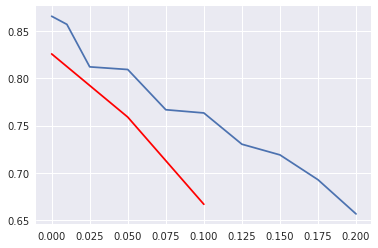

In [47]:
seaborn.set()
plt.plot(gru_noise, gru_acc)
plt.plot(lstm_noise, lstm_acc, 'r')

In [1]:
model

NameError: name 'model' is not defined